In [1]:
import util
import xarray 
import numpy as np
ds = util.get_dataset()
sst_ds = xarray.open_dataset("../data/sst.wkmean.1990-present.nc")
sst_ds = sst_ds.assign_coords(lon=(((sst_ds.lon + 180) % 360) - 180)) ## Use consistent longitude
train_storms,valid_storms,test_storms = util.train_validation_test(ds,seed=42)

In [15]:
import numpy as np 

def coriolis_parameter(lat):
    return 2*np.sin(np.deg2rad(lat))

def make_X_y(ds,selected_storms,timesteps=5):
    Xout = []
    yout =[]
    storms = []
    for stormidx,storm in enumerate(selected_storms):
        usa_pres = ds.usa_pres.loc[storm]
        usa_wind = ds.usa_wind.loc[storm]
        ## All enteries have 360 points.
        valid_coords = ~(np.isnan(usa_wind) | np.isnan(usa_pres))
        lat = ds.lat.loc[storm][valid_coords]
        lon = ds.lon.loc[storm][valid_coords]
        storm_speed = ds.storm_speed.loc[storm][valid_coords]
        storm_dir = ds.storm_dir.loc[storm][valid_coords]
        u = storm_speed*np.sin(np.deg2rad(storm_dir))
        v = storm_speed*np.cos(np.deg2rad(storm_dir))


        usa_pres = usa_pres[valid_coords]
        usa_wind = usa_wind[valid_coords]
        time = ds.time.loc[storm][valid_coords]
        cor_param = coriolis_parameter(lat)
        try:
            sst = sst_ds.sst.interp(time=time,lat=lat,lon=lon)
        except ValueError:
            continue
        if np.isnan(sst).any():
            continue

        X = np.transpose(np.array([usa_wind,usa_pres,u,v,cor_param,sst,lat,lon]))
        for i in range(0,len(usa_wind)):
            if i+timesteps+1>=len(usa_wind):
                break
            Xout.append(X[i:i+timesteps])
            yout.append(X[i+timesteps+1][:4])
            storms.append(stormidx)
    return np.stack(Xout),np.stack(yout),np.array(storms)

In [16]:
TIMEPOINTS = 3
x_train,y_train,storm_train = make_X_y(ds,train_storms,TIMEPOINTS)
x_valid,y_valid,storm_valid = make_X_y(ds,valid_storms,TIMEPOINTS)

### Training

In [17]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=500,max_depth=10,n_jobs=-1)
rf.fit(x_train.reshape((x_train.shape[0],-1)),y_train)

RandomForestRegressor(max_depth=10, n_estimators=500, n_jobs=-1)

In [18]:
pred_valid = rf.predict(x_valid.reshape((x_valid.shape[0],-1)))



In [19]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_valid,pred_valid,multioutput='raw_values',squared=False)

array([4.67939208, 3.76320124, 3.21477636, 3.13511125])

## Tune Timepoints 

In [145]:
from sklearn.metrics import mean_squared_error
for timepoints in [1,3,5,10,15,20,50]:
    print(f"--- Timepoints {timepoints} ---")
    x_train_i,y_train_i,storm_train_i = make_X_y(ds,train_storms,timepoints)
    x_valid_i,y_valid_i,storm_valid_i = make_X_y(ds,valid_storms,timepoints)

    rf = RandomForestRegressor(n_estimators=500,max_depth=10,n_jobs=-1)
    rf.fit(x_train_i.reshape((x_train_i.shape[0],-1)),y_train_i)
    y_pred_i= rf.predict(x_valid_i.reshape((x_valid_i.shape[0],-1)))
    print(mean_squared_error(y_valid_i,y_pred_i,multioutput='raw_values',squared=False))

--- Timepoints 1 ---
[5.35332694 4.09920717 3.0206419  2.92950528]
--- Timepoints 3 ---
[4.67110725 3.75929915 3.21514095 3.13348008]
--- Timepoints 5 ---
[4.75908144 3.82082262 3.24682721 3.16460579]
--- Timepoints 10 ---
[4.85333398 3.91229797 3.36841556 3.22959938]
--- Timepoints 15 ---
[4.94124005 4.05038669 3.43011289 3.29702668]
--- Timepoints 20 ---


KeyboardInterrupt: 

## Cross Val Tune

In [10]:
from sklearn.model_selection import GridSearchCV,GroupKFold
cv = GroupKFold(n_splits=10)
hp_search_rf = RandomForestRegressor(n_jobs=-1)
search = GridSearchCV(hp_search_rf,{"n_estimators":[100,250,500],"max_depth":[2,5,10]},cv=cv)
search.fit(x_train.reshape((x_train.shape[0],-1)),y_train,groups=storm_train)


GridSearchCV(cv=GroupKFold(n_splits=10),
             estimator=RandomForestRegressor(n_jobs=-1),
             param_grid={'max_depth': [2, 5, 10],
                         'n_estimators': [100, 250, 500]})

In [14]:
rf_optim = search.best_estimator_

### Prediction on full test set

In [20]:
from sklearn.metrics import mean_squared_error
X_test,y_test,group_test = make_X_y(ds,test_storms,TIMEPOINTS)
y_test_pred = rf.predict(X_test.reshape((X_test.shape[0],-1)))

mean_squared_error(y_test,y_test_pred,multioutput='raw_values',squared=False)

array([5.06882285, 3.74208631, 3.07623967, 3.31741721])

## Sample Curves

In [21]:
from geopy.distance import distance
from geopy.point import Point
from datetime import timedelta
def get_predicted_latlon_from_speed(lat,lon,u,v):
    d = np.sqrt(u**2 + v**2)*3*1.852 ## convert to kilometers across 6 hours intervals
    bearing = np.rad2deg(np.arctan2(u,v))
    predicted = distance(kilometers=d).destination(Point(latitude=lat,longitude=lon),bearing)
    return predicted.latitude,predicted.longitude




def recursive_prediction(initial_x,model,length,start_time):
    y = np.zeros((length,6))
    timestep = initial_x.shape[0]
    y[:timestep] = initial_x[:,[0,1,2,3,6,7]]
    x = initial_x
    for step in range(length - timestep):
        out = model.predict(x.reshape(1,-1))[0]
        uMax,Pmin,u,v = out
        old_lat,old_lon = x[-1,-2],x[-1,-1]
        interp_lat,interp_lon = get_predicted_latlon_from_speed(old_lat,old_lon,u,v)

        cor_param= coriolis_parameter(interp_lat)
        sst = float(sst_ds.sst.interp(time=start_time+np.timedelta64((3)*(step+1),'h'),lat=interp_lat,lon=interp_lon))
        if np.isnan(sst):
            sst = x[-1,5] ## use last value if not possible
        y[step+timestep] = [uMax,Pmin,u,v,interp_lat,interp_lon]
        x = np.roll(x,-1,axis=0)
        x[-1] = [uMax,Pmin,u,v,cor_param,sst,interp_lat,interp_lon]
    return y 


In [22]:
def get_storm_seeds(ds,selected_storms,timestep:int=5):
    """
    Similar but generates X, vector of storm seed and y, vector of entire storm prediction track
    """
    Xout,yout,start_times=[],[],[]

    for storm in selected_storms:
        usa_pres = ds.usa_pres.loc[storm]
        usa_wind = ds.usa_wind.loc[storm]
        ## All enteries have 360 points.
        valid_coords = ~(np.isnan(usa_wind) | np.isnan(usa_pres))
        lat = ds.lat.loc[storm][valid_coords]
        lon = ds.lon.loc[storm][valid_coords]
        storm_speed = ds.storm_speed.loc[storm][valid_coords]
        storm_dir = ds.storm_dir.loc[storm][valid_coords]
        u = storm_speed*np.sin(np.deg2rad(storm_dir))
        v = storm_speed*np.cos(np.deg2rad(storm_dir))
        usa_pres = usa_pres[valid_coords]
        usa_wind = usa_wind[valid_coords]
        time = ds.time.loc[storm][valid_coords]
        cor_param = coriolis_parameter(lat)
        try:
            sst = sst_ds.sst.interp(time=time,lat=lat,lon=lon)
        except ValueError:
            continue
        if np.isnan(sst).any():
            continue
        if timestep+1>=len(usa_wind):
            continue

        X = np.transpose(np.array([usa_wind,usa_pres,u,v,cor_param,sst,lat,lon]))
    
        Xout.append(X[:timestep])
        yout.append(X)
        start_times.append(time[timestep].values)
    return Xout,yout,np.array(start_times)

In [23]:
test_storm_seed,test_tracks,test_start_times = get_storm_seeds(ds,test_storms,timestep=TIMEPOINTS)


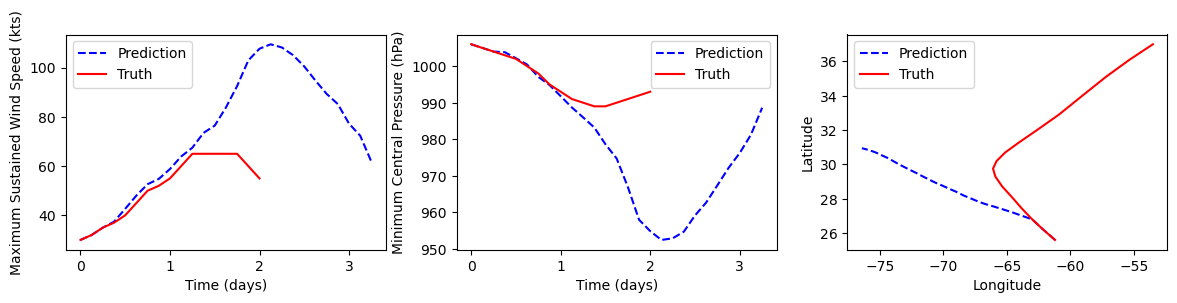

In [36]:
import matplotlib.pyplot as plt
STORM = 99
prediction_length = len(test_tracks[STORM]) + 10
storm_prediction = recursive_prediction(test_storm_seed[STORM],rf,prediction_length,test_start_times[STORM])
t=np.arange(0,prediction_length/8,0.125)
fig,ax = plt.subplots(ncols=3,nrows=1,figsize=(12,3))
fig.tight_layout(pad=2)
ax[0].plot(t,storm_prediction[:,0],'b--',label='Prediction')
ax[0].plot(t[:len(test_tracks[STORM])],test_tracks[STORM][:,0],'r-',label='Truth')
ax[0].set_xlabel("Time (days)")
ax[0].set_ylabel("Maximum Sustained Wind Speed (kts)")
ax[0].legend()
ax[1].plot(t,storm_prediction[:,1],'b--',label='Prediction')
ax[1].plot(t[:len(test_tracks[STORM])],test_tracks[STORM][:,1],'r-',label='Truth')
ax[1].set_xlabel("Time (days)")
ax[1].set_ylabel("Minimum Central Pressure (hPa)")
ax[1].legend()
ax[2].plot(storm_prediction[:,-1],storm_prediction[:,-2],'b--',label='Prediction')
ax[2].plot(test_tracks[STORM][:,-1],test_tracks[STORM][:,-2],'r-',label='Truth')
ax[2].set_xlabel("Longitude")
ax[2].set_ylabel("Latitude")
ax[2].legend()
fig.savefig(f"plots/rf_test_{STORM}.png")

### Common Profile

In [38]:
predictions = [recursive_prediction(test_storm_seed[storm],rf,prediction_length,test_start_times[storm]) for storm in range(len(test_storm_seed))]

In [40]:
max_speed_truth = np.array([max(track[:,0]) for track in test_tracks])
max_speed_pred = np.array([max(track[:,0]) for track in predictions])

time_max_speed_truth = np.array([np.argmax(track[:,0]) for track in test_tracks])
time_max_speed_pred = np.array([np.argmax(track[:,0]) for track in predictions])

In [41]:
mean_squared_error(max_speed_truth,max_speed_pred,squared=False)

55.41023771219612

In [42]:
mean_squared_error(time_max_speed_truth,time_max_speed_pred,squared=False)

23.770209446760393

In [43]:
five_day_forecast = [recursive_prediction(test_storm_seed[s],rf,8*5,test_start_times[s]) for s in range(len(test_storm_seed))]

In [44]:
five_day_forecast = np.array(five_day_forecast)

In [45]:
five_day_forecast_median = np.median(five_day_forecast,axis=0)
five_day_forecast_lower = np.percentile(five_day_forecast,q=5,axis=0)
five_day_forecast_upper = np.percentile(five_day_forecast,q=95,axis=0)

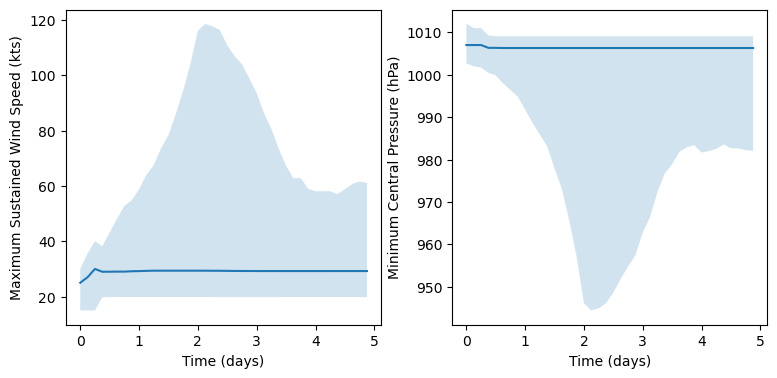

In [46]:
t = np.arange(0,5,0.125)
fig,ax = plt.subplots(1,2,figsize=(8,4))
fig.tight_layout(pad=2.0)
ax[0].plot(t,five_day_forecast_median[:,0])
ax[0].fill_between(t,five_day_forecast_lower[:,0],five_day_forecast_upper[:,0],alpha=0.2)
ax[0].set_xlabel("Time (days)")
ax[0].set_ylabel("Maximum Sustained Wind Speed (kts)")

ax[1].plot(t,five_day_forecast_median[:,1])
ax[1].fill_between(t,five_day_forecast_lower[:,1],five_day_forecast_upper[:,1],alpha=0.2)
ax[1].set_xlabel("Time (days)")
ax[1].set_ylabel("Minimum Central Pressure (hPa)")
fig.savefig("plots/median_profiles_rf.png")